# TimeSHAP

## Import

In [1]:
import numpy as np

import matplotlib.pyplot as plt

# Import functions from modular scripts
from TimeSHAP import (
    plot_predictions, avg_rul,  get_random_sequence,
    local_event_explainer, plot_local_event_explanation,
    compute_event_explanation, plot_event_explanation,
)
from Load_and_Preprocess_Aachen import preprocess_aachen_dataset
from LSTM_Model_Training import load_model_structure_and_weights

from timeshap.explainer.pruning import local_pruning

## Test data

This section defines parameters for data preprocessing and analysis:
- `file_path`: Path to the Aachen dataset (ISEA battery degradation data).
- `test_cell_count = 3`: Number of test cells, balancing computational efficiency and representativeness.
- `random_state = 52`: Ensures reproducibility of random splits.
- `n_samples = 1000`: Number of background samples for SHAP, chosen for computational feasibility.
- `eol_capacity = 0.65`: End-of-Life threshold (65% of initial capacity), a common industry standard for battery RUL.
- `global_relative = True`: Enables relative position normalization for SHAP aggregation.

In [2]:
# Define the file path for the dataset
file_path = '/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/data/Degradation_Prediction_Dataset_ISEA.mat'

# Define the number of test cells to be used
test_cell_count = 3

# Set the global random seed for reproducibility
random_state = 52
np.random.seed(random_state)

# Number of sampels to be used for the SHAP explainer
n_samples = 1000

# EOL threshold
eol_capacity = 0.65

global_relative = True 

## Load data

In [3]:
# Load and preprocess the Aachen dataset
preprocessed_full = preprocess_aachen_dataset(
    file_path, eol_capacity=eol_capacity, test_cell_count=test_cell_count,
    random_state=random_state, phase=None, log_transform=False  # No log transform applied
)

# Extract training, validation, and test sets for LSTM input and normalized RUL targets
X_train_lstm = preprocessed_full["X_train"]  # Training sequences
X_test_lstm = preprocessed_full["X_test"]    # Test sequences
y_test_norm = preprocessed_full["y_test"]    # Normalized test RUL
y_max = preprocessed_full["y_max"]           # Maximum RUL for rescaling

## Load Model

In [4]:
model = load_model_structure_and_weights('model_20250217_RUL65')
f = lambda x: model.predict(x)

Checking for model files in the following paths:
Structure file: Aachen/Models/model_20250217_RUL65.structure.json
Weights file: Aachen/Models/model_20250217_RUL65.weights.h5
Model loaded from Aachen/Models/model_20250217_RUL65.structure.json and Aachen/Models/model_20250217_RUL65.weights.h5


## Evaluate Model

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3934e-04 - mae: 0.0159
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Rescaled Test MAE: 27.099970756098628


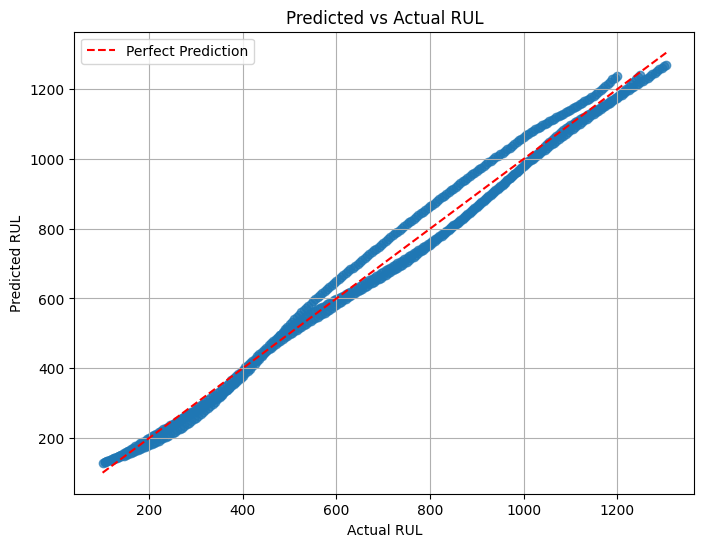

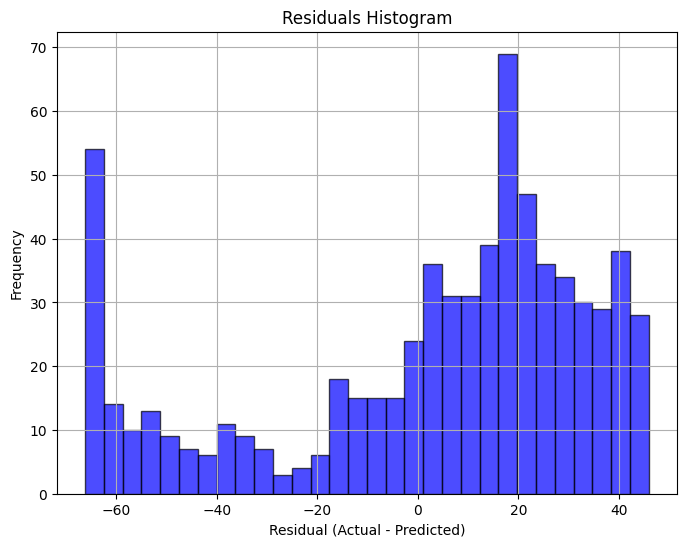

In [5]:
test_loss, test_mae = model.evaluate(X_test_lstm, y_test_norm, verbose=1)
test_mae_rescaled = test_mae * y_max
y_pred = model.predict(X_test_lstm).flatten() * y_max

y_test_rescaled = y_test_norm * y_max
print(f"Rescaled Test MAE: {test_mae_rescaled}")

plot_predictions(y_test_rescaled, y_pred)

### Background data

In [6]:
average_event = avg_rul(X_train_lstm)

average_event.shape

(1, 1)

In [7]:
# Squeeze the last dimension for easier handling (from (7998, 288, 1) to (7998, 288))
data_2d = X_train_lstm.squeeze(axis=2)

# Create a mask where values are non-zero
mask = data_2d != 0

# Compute the sum of non-zero values for each time step
sum_per_timestep = np.sum(data_2d * mask, axis=0)

# Count non-zero values for each time step
count_per_timestep = np.sum(mask, axis=0)

# Avoid division by zero by setting mean to 0 where no non-zero values exist
# (though with 7998 sequences, this is unlikely unless all values at a timestep are padded)
mean_per_timestep = np.where(count_per_timestep > 0, 
                            sum_per_timestep / count_per_timestep, 
                            0)

# Reshape to (288, 1) to match your data’s feature dimension
mean_per_timestep = mean_per_timestep.reshape(288, 1)

average_event = mean_per_timestep

average_event

array([[0.97932778],
       [0.97550132],
       [0.97170276],
       [0.96790543],
       [0.96412372],
       [0.96039098],
       [0.95668851],
       [0.95297585],
       [0.94931539],
       [0.94567606],
       [0.94205113],
       [0.93846234],
       [0.93492331],
       [0.93137603],
       [0.92786362],
       [0.9243965 ],
       [0.92093531],
       [0.9175298 ],
       [0.91413442],
       [0.91077915],
       [0.907445  ],
       [0.90415192],
       [0.90087607],
       [0.89767013],
       [0.8944558 ],
       [0.89130402],
       [0.88817173],
       [0.88506231],
       [0.8820085 ],
       [0.87898314],
       [0.87599759],
       [0.8730239 ],
       [0.87012228],
       [0.86723938],
       [0.86439343],
       [0.8615669 ],
       [0.8587772 ],
       [0.85600883],
       [0.85329804],
       [0.85057013],
       [0.84790505],
       [0.84524664],
       [0.84260759],
       [0.84000755],
       [0.83742906],
       [0.83486931],
       [0.83231117],
       [0.829

## Local Explanations

The SHAP value for feature \(i\) is computed as:

$$
\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} [f(S \cup \{i\}) - f(S)]
$$

where \(N\) is the set of all features, \(S\) is a subset excluding \(i\), and \(f\) is the model prediction function. TimeSHAP extends this to temporal events, aggregating contributions over sequence steps.

In [8]:
from timeshap.explainer.pruning import local_pruning

# Define prediction function
f = lambda x: model.predict(x, verbose=0)

prun_dict = {'tol': 0.05}

# Select a random test sequence
seq_idx = np.random.randint(0, len(X_test_lstm))

### Why different Shap-results

- Non-Trimmed Sequences: The explanation includes padded zeros, which leads to low but volatile Shapley values across the entire sequence—even in regions that the model largely ignores.

- Trimmed Sequences: Only the meaningful, nonzero parts are considered. The Shapley values become more consistent and focused on the parts of the sequence that truly affect the model's prediction.

This behavior suggests that your model is effectively ignoring the padded sections during prediction, and the explanation method is reflecting that by producing more stable, interpretable results when the padding is removed.

### Normalize by relative Position

When you average over all sequences for each absolute event index, you run into two issues:

- Early Events: For long sequences, many of the early events are padded (or absent) and show near‐zero Shapley values, which “pulls” the mean down—even if some short sequences have higher values there.
- Late Events: For long sequences, the later events (which have high Shapley values) occur only in those sequences. If many sequences are shorter and do not have those events at all, then the average at those indices is computed over a smaller sample, and the overall mean can be “dragged” down by the large number of zeros (or missing values) from the shorter sequences.

Therfore Shapley values can be aggregated across relative data into bins.

In [32]:
# Get a random trimmed sequence from the test set.
trimmed_sequence = get_random_sequence(X_test_lstm, 660, trimmed=True)
print(trimmed_sequence.shape)

x = trimmed_sequence.shape[1]  # Get the number of time steps (e.g., 261)
trimmed_average_event = average_event[:x].reshape(1, x, 1)  # Slice first x elements and reshape

# Compute the local event explanation for the trimmed sequence
event_explanation = local_event_explainer(f, trimmed_sequence, trimmed_average_event, pruned_idx=0, nsamples=1000)

# Output the explanation
print(event_explanation)

trimmed_sequence.shape



Selected index: 660
Trimmed sequence shape: (1, 209, 1)
(1, 209, 1)
     Shapley Value  Sequence Value
0         0.000000        0.983138
1         0.000000        0.977949
2         0.000000        0.972805
3         0.000000        0.967710
4         0.000000        0.962664
..             ...             ...
204       0.020382        0.326768
205      -0.001175        0.322081
206      -0.028766        0.317331
207      -0.049946        0.312509
208      -0.064280        0.307602

[209 rows x 2 columns]


(1, 209, 1)

In [26]:
# Plot the event explanation.
plot_local_event_explanation(event_explanation)

In [16]:
trimmed_sequence

array([[[0.9719559 ],
        [0.968568  ],
        [0.9651899 ],
        [0.9618224 ],
        [0.95846623],
        [0.9551222 ],
        [0.951791  ],
        [0.94847345],
        [0.94517034],
        [0.94188243],
        [0.9386105 ],
        [0.93535525],
        [0.9321175 ],
        [0.92889804],
        [0.92569757],
        [0.9225169 ],
        [0.91935676],
        [0.9162179 ],
        [0.91310126],
        [0.9100074 ],
        [0.9069372 ],
        [0.9038914 ],
        [0.90087074],
        [0.89787596],
        [0.89490795],
        [0.8919674 ],
        [0.8890551 ],
        [0.88617176],
        [0.8833182 ],
        [0.88049513],
        [0.8777034 ],
        [0.87494373],
        [0.8722164 ],
        [0.8695172 ],
        [0.86684436],
        [0.864197  ],
        [0.8615745 ],
        [0.85897595],
        [0.8564007 ],
        [0.853848  ],
        [0.851317  ],
        [0.8488069 ],
        [0.8463171 ],
        [0.8438467 ],
        [0.84139496],
        [0

## Global Explanations

In [34]:
# Count non-zero time steps per sequence
non_zero_counts = np.sum(X_test_lstm != 0, axis=(1, 2))  # Shape (7998,)
mask = non_zero_counts >= 100  # Keep sequences with at least 100 non-zero steps
filtered_sequences = X_test_lstm[mask]  # Shape (n_filtered, 288, 1)

filtered_sequences.shape

# Trim to first 100 time steps
trimmed_sequences = filtered_sequences[:, :100, :]  # Shape (n_filtered, 100, 1)

trimmed_sequences.shape

# Trimmed average event
trimmed_average_event = average_event[:100].reshape(1, 100)


In [35]:
event_data_bin = compute_event_explanation(f, trimmed_sequences, baseline=trimmed_average_event, relative=False, random_seed=random_state, nsamples=1000, verbose=True)


Sequence 0: original length = 100, trimmed length = 100, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Sequence 1: original length = 100, trimmed length = 100, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Sequence 2: original length = 100, trimmed length = 100, event indices: [0

In [37]:
global_event_chart = plot_event_explanation(event_data_bin, relative=False)
global_event_chart.show()

In [17]:
event_data = compute_event_explanation(f, X_test_lstm, baseline=average_event, relative=False, random_seed=random_state, nsamples=1000, num_bins=30, verbose=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Sequence 0: original length = 272, trimmed length = 21, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sequence 1: original length = 272, trimmed length = 22, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sequence 2: original length = 272, trimmed length = 23, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sequence 3: original length = 272, trimmed length = 24, event indices: [0, 1, 2, 3, 4, 5, 

In [18]:
global_event_chart = plot_event_explanation(event_data, relative=False)
global_event_chart.show()

In [ ]:
# --- Stability Evaluation --- Not implemented
#stability_results = evaluate_stability(f, X_test_lstm, noise_level=0.01, num_runs=5, num_bins=20)
#plot_stability(stability_results)

In [46]:
trimmed_sequence = get_random_sequence(X_test_lstm, 206, trimmed=True)

Selected index: 206
Trimmed sequence shape: (1, 227, 1)


In [74]:
# Compute the local event explanation for the trimmed sequence.
event_explanation = local_event_explainer(f, trimmed_sequence, average_event, pruned_idx=0, nsamples=1000)

# Plot the event explanation.
plot_local_event_explanation(event_explanation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [69]:
prun_dict = {'tol': 0.005}

# Pruning the sequence
pruned_sequence, prun_idx = local_pruning(f, 
                                data=trimmed_sequence, 
                                pruning_dict=prun_dict,
                                baseline=average_event)
                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [70]:
pruned_sequence

,Coalition,t (event index),Shapley Value
0,Sum of contribution of events > t,0,1.490116e-08
1,Sum of contribution of events ≤ t,0,-4.549102e-01
2,Sum of contribution of events > t,-1,-4.831913e-01
3,Sum of contribution of events ≤ t,-1,2.828106e-02
4,Sum of contribution of events > t,-2,-6.569493e-01
...,...,...,...
451,Sum of contribution of events ≤ t,-225,1.306966e-03
452,Sum of contribution of events > t,-226,-4.544932e-01
453,Sum of contribution of events ≤ t,-226,-4.169792e-04
454,Sum of contribution of events > t,-227,-4.549102e-01


In [71]:
prun_idx

-51

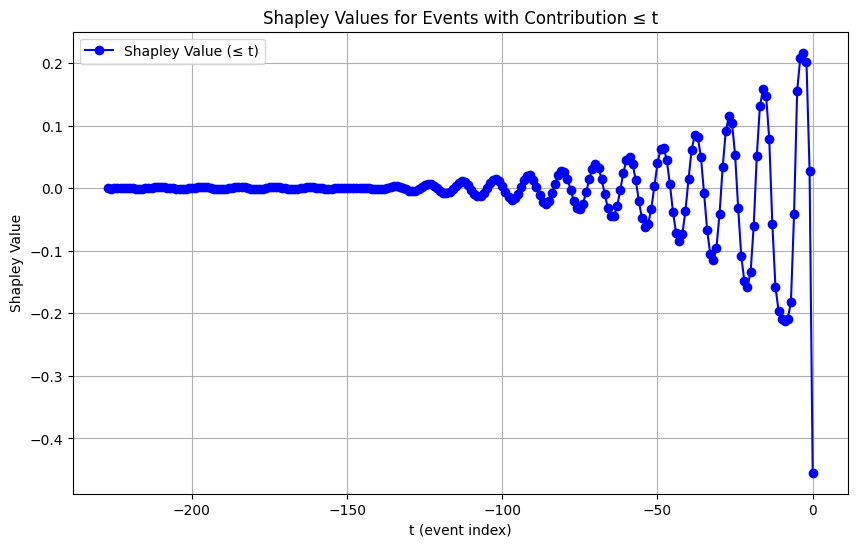

In [72]:
df = pruned_sequence

# Filter the DataFrame for rows where the 'Coalition' column indicates contributions ≤ t.
# (Adjust the string if your DataFrame uses a different notation.)
df_filtered = df[df['Coalition'] == 'Sum of contribution of events ≤ t']

# Now, plot the filtered data.
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['t (event index)'], df_filtered['Shapley Value'],
         marker='o', linestyle='-', color='blue', label='Shapley Value (≤ t)')

plt.xlabel('t (event index)')
plt.ylabel('Shapley Value')
plt.title('Shapley Values for Events with Contribution ≤ t')
plt.legend()
plt.grid(True)
plt.show()



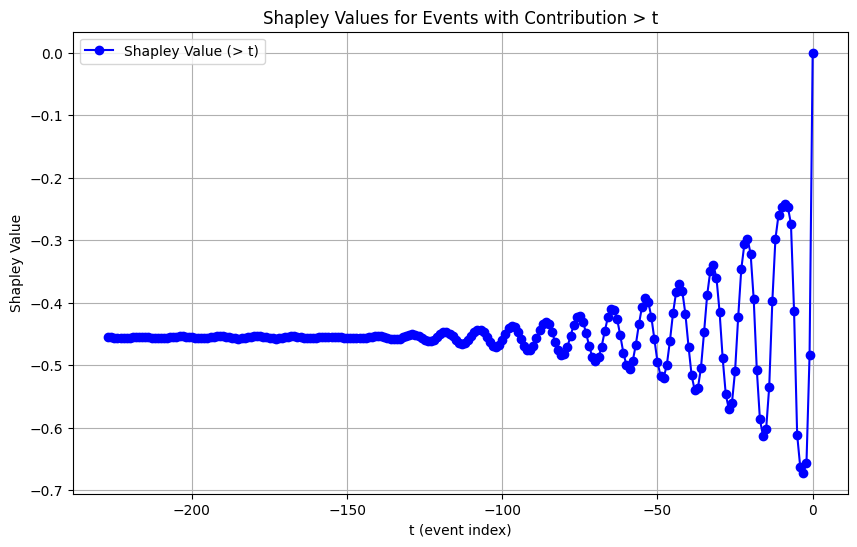

In [73]:
df = pruned_sequence

# Filter the DataFrame for rows where the 'Coalition' column indicates contributions > t.
df_filtered = df[df['Coalition'] == 'Sum of contribution of events > t']

# Now, plot the filtered data.
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['t (event index)'], df_filtered['Shapley Value'],
         marker='o', linestyle='-', color='blue', label='Shapley Value (> t)')

plt.xlabel('t (event index)')
plt.ylabel('Shapley Value')
plt.title('Shapley Values for Events with Contribution > t')
plt.legend()
plt.grid(True)
plt.show()


### Why different Shap-results

- Non-Trimmed Sequences: The explanation includes padded zeros, which leads to low but volatile Shapley values across the entire sequence—even in regions that the model largely ignores.

- Trimmed Sequences: Only the meaningful, nonzero parts are considered. The Shapley values become more consistent and focused on the parts of the sequence that truly affect the model's prediction.

This behavior suggests that your model is effectively ignoring the padded sections during prediction, and the explanation method is reflecting that by producing more stable, interpretable results when the padding is removed.

### Normalize by relative Position

When you average over all sequences for each absolute event index, you run into two issues:

- Early Events: For long sequences, many of the early events are padded (or absent) and show near‐zero Shapley values, which “pulls” the mean down—even if some short sequences have higher values there.
- Late Events: For long sequences, the later events (which have high Shapley values) occur only in those sequences. If many sequences are shorter and do not have those events at all, then the average at those indices is computed over a smaller sample, and the overall mean can be “dragged” down by the large number of zeros (or missing values) from the shorter sequences.

Therfore Shapley values can be aggregated across relative data into bins.